In [146]:
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json
import time
import datetime
import missingno as msno
import matplotlib.pyplot as plt

In [145]:
now = datetime.datetime.now().strftime('%Y%m%d')  # used in naming the CSV output

## Set parameters

In [171]:
# what you want to call the filename
articles_name = 'coronavirus'

In [172]:
api_key = # get yours at https://developer.nytimes.com/
api_secret = # it's super easy

In [174]:
# filtering by date so I don't have to paginate like crazy. 6 month period looks to have only around 1000 hits
BEGIN_DATE=20200601
END_DATE=20200701

query_text = 'coronavirus'
page_number=1
section_name = 'Food'
type_of_material = 'Recipe'

## define functions

In [149]:
# creates a URL with specified parameters to call NYT API.
# You can play with more filters, this is basic
def generate_url(page_number,
                 begin_date=BEGIN_DATE,
                 end_date=END_DATE,
                 query=query_text):
    url=(f'http://api.nytimes.com/svc/search/v2/articlesearch.json?'\
     f'q=("{query_text}")&fq=source:("The%20New%20York%20Times")&document_type:("article")&sort=oldest&api-key={api_key}'\
     f'&begin_date={begin_date}&end_date={end_date}&page={page_number}')
    return(url)

In [150]:
# returns the latest date from the dataframe, to use as the start date for the next API call
def get_max_date(df):
    max_date = int(str(df['pub_date'].max())[0:10].replace('-',''))
    print(f'max date: {max_date}')
    return(max_date)

In [152]:
#parses JSON into dataframe
def get_article_dataframe(r):
    df=json_normalize(json.loads(r.text)['response']['docs'])
    return(df)

In [153]:
# number of 10-article pages to paginate through
def get_number_pages(r):
    try:
        total_articles=json.loads(r.text)['response']['meta']['hits']
    except:
        total_articles=0
    number_pages = round(total_articles / 10)
    print(f'number_pages: {number_pages}')
    return(number_pages)


Check how many pages your query returns. There are 10 articles per page

In [175]:
get_number_pages(requests.get(generate_url(page_number=1)))

number_pages: 189


189

Gets the number of page to loop through. Consider adding > 0 clause to page length

In [176]:
df_list = [] # initializing the list of dataframes we'll output to

max_date = BEGIN_DATE # this is initially the starting date for the analysis, it will get updated

## Pull the article dataframes

Below, looping through all of the pages in the result, 200 at a time. Each time we go through 200 pages, we have to make a new request, and we start the new request at the "max_date", the latest date in the previous dataframe. This can take a while since we have to pause each iteration so as not to overload the API

In [177]:
number_pages=1
while number_pages > 0:
    url=generate_url(page_number=1, begin_date=max_date+1)
    r=requests.get(url)    
    number_pages=get_number_pages(r)
    for i in range(1, min(200,number_pages)):  # 200 because NYT API only lets you paginate through page 200
        print(f'page: {i}')
        url=generate_url(page_number=i, begin_date=max_date+1)
        try:
            r=requests.get(url)
            df=get_article_dataframe(r)
            df_list.append(df)
            time.sleep(10)
        except:
            time.sleep(300) # wait five minutes
    max_date = get_max_date(df) 
    print(f'max date: {max_date}')
    print(f'length dataframe list: {len(df_list)}')

number_pages: 181
page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8
page: 9
page: 10
page: 11
page: 12
page: 13
page: 14
page: 15
page: 16
page: 17
page: 18
page: 19
page: 20
page: 21
page: 22
page: 23
page: 24
page: 25
page: 26
page: 27
page: 28
page: 29
page: 30
page: 31
page: 32
page: 33
page: 34
page: 35
page: 36
page: 37
page: 38
page: 39
page: 40
page: 41
page: 42
page: 43
page: 44
page: 45
page: 46
page: 47
page: 48
page: 49
page: 50
page: 51
page: 52
page: 53
page: 54
page: 55
page: 56
page: 57
page: 58
page: 59
page: 60
page: 61
page: 62
page: 63
page: 64
page: 65
page: 66
page: 67
page: 68
page: 69
page: 70
page: 71
page: 72
page: 73
page: 74
page: 75
page: 76
page: 77
page: 78
page: 79
page: 80
page: 81
page: 82
page: 83
page: 84
page: 85
page: 86
page: 87
page: 88
page: 89
page: 90
page: 91
page: 92
page: 93
page: 94
page: 95
page: 96
page: 97
page: 98
page: 99
page: 100
page: 101
page: 102
page: 103
page: 104
page: 105
page: 106
page: 107
page: 108
page: 109


In [186]:
df = pd.concat(df_list)

/Users/josephhovde/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [181]:
# here, taking only the columns i want to use in analysis
write_df = df[['_id', 'abstract', 'byline.original', 'headline.main', 'headline.name', 'headline.print_headline', 'headline.sub',
   'lead_paragraph', 'news_desk', 'print_page', 'pub_date', 'snippet', 'word_count']]

In [182]:
# casting the date as a date type
df['pub_date']=pd.to_datetime(df['pub_date'])

In [184]:
# making sure the filename is what we want
filename = f'nyt_{articles_name}-{now}.csv'
print(filename)

nyt_coronavirus-20200627.csv


In [185]:
# save file as a csv
write_df.to_csv(filename, index=False)

## See trend over time

In [167]:
# cut dates different ways so you can see weekly, monthly, yearly trends
df['dt']=pd.DatetimeIndex(df['pub_date']).date
df['year'] = pd.DatetimeIndex(df['pub_date']).year
df['year_month'] = pd.to_datetime(df['pub_date']).dt.to_period('M')
df['year_week'] = pd.to_datetime(df['pub_date']).dt.to_period('W')

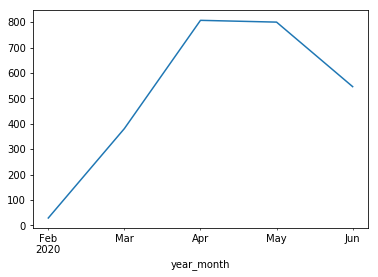

In [168]:
df.groupby('year_month').count()['headline.print_headline'].plot()

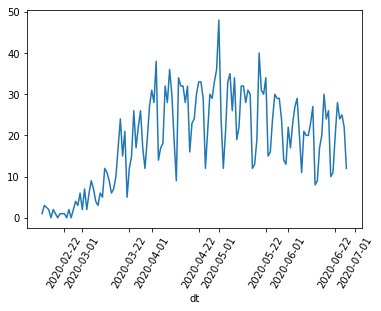

In [170]:
df.groupby('dt').count()['headline.print_headline'].plot()
plt.xticks(rotation=60)
plt.show()